In [1]:
import numpy as np
import tensorflow as tf

from deep_boltzmann.models.mueller_potential import MuellerPotential

import matplotlib.pyplot as plt

In [2]:
params = MuellerPotential.params_default
params['k'] = 0.1
m_pot = MuellerPotential(params=params)

In [3]:
x_grid = np.arange(-1.5, 1.201, 0.01, dtype='float32')
y_grid = np.arange(-0.2, 2.001, 0.01, dtype='float32')
xx, yy = np.meshgrid(x_grid, y_grid)
x = xx.flatten()
y = yy.flatten()
dat = np.vstack([x, y]).T

In [4]:
energies = m_pot.energy_tf(dat).numpy()

In [5]:
plot_energies = energies.reshape(xx.shape)

<IPython.core.display.Javascript object>


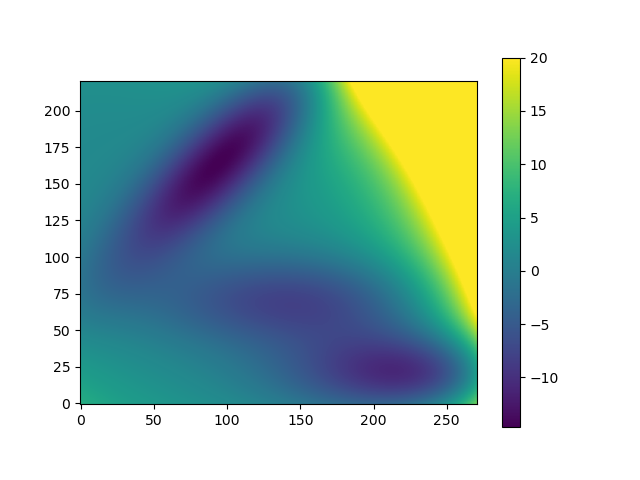

In [6]:
%matplotlib notebook

# im = plt.contourf(xx, yy, plot_energies.clip(max=20), 40)
im = plt.imshow(plot_energies, origin='lower', vmax=20.0)

plt.colorbar(im, ax=plt.gca())

In [7]:
#Define move based on adding Gaussian noise and MC simulation protocol

def moveGaussian(conf, currU, B, energy_func, energy_params={}, std=1.0):
    #Add Gaussian noise with std to all elements of conf
    noise = np.random.normal(loc=0.0, scale=std, size=conf.shape).astype(np.float32)
    new_conf = conf + noise
    #Compute new potential energy with energy_func
    newU = energy_func(new_conf, **energy_params).numpy()
    #Compute acceptance probability
    logPacc = -B*(newU - currU)
    return logPacc, new_conf, newU

#Define a function to run an MC simulation
def run_mc_sim(data, potential,
               num_steps=int(1e06), write_freq=1000,
               num_parallel=1000,
               noise_mag=1.0):

    rand_inds = np.random.choice(data.shape[0], size=num_parallel, replace=False)
    curr_config = data[rand_inds]
    curr_U = potential(curr_config).numpy()

    num_acc = np.zeros(num_parallel)
    
    traj = np.zeros((num_steps//write_freq + 1, num_parallel)+data.shape[1:], dtype='float32')
    traj_pot = np.zeros((num_steps//write_freq + 1, num_parallel), dtype='float32')
    traj[0, ...] = curr_config
    traj_pot[0, ...] = curr_U

    for i in range(num_steps):

        move_info = moveGaussian(curr_config, curr_U, 1.0, potential, std=noise_mag)
        rand_logP = np.log(np.random.random(num_parallel))
        to_acc = (move_info[0] > rand_logP)
        num_acc[to_acc] += 1.0
        curr_config[to_acc] = move_info[1][to_acc]
        curr_U[to_acc] = move_info[2][to_acc]

        if i%write_freq == 0:
            traj[i//write_freq + 1, ...] = curr_config
            traj_pot[i//write_freq + 1, ...] = curr_U

    print('\tTotal avg acc rate: %f'%(np.sum(num_acc)/(num_steps*num_parallel)))

    return curr_config, curr_U, traj, traj_pot, num_acc



In [8]:
out_confs, out_U, traj, traj_U, n_acc = run_mc_sim(dat, m_pot.energy_tf,
                                                   noise_mag=0.1,
                                                   num_parallel=int(1e04),
                                                   num_steps=int(1e05), write_freq=100)

	Total avg acc rate: 0.466764


In [9]:
traj.shape

(1001, 10000, 2)

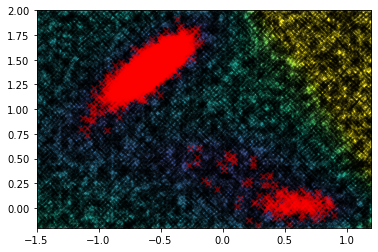

In [10]:
%matplotlib inline

plt.contourf(xx, yy, plot_energies.clip(max=20), 40)
plt.scatter(traj[0, :, 0], traj[0, :, 1], color='k', marker='x', alpha=0.4)
plt.scatter(traj[-1, :, 0], traj[-1, :, 1], color='red', marker='x', alpha=0.4)
# plt.plot(traj[:, 100, 0], traj[:, 100, 1], color='red', marker='x', alpha=0.4)

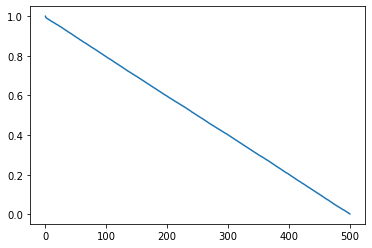

In [11]:
auto_corr = np.correlate(traj_U[500:, 0], traj_U[500:, 0], mode='full')
auto_corr = auto_corr[auto_corr.size//2:]
auto_corr /= np.max(auto_corr)
plt.plot(auto_corr)

In [12]:
eq_data = traj[610::40, ...]
eq_U = traj_U[610::40, ...]

print(eq_data.shape, eq_U.shape)

(10, 10000, 2) (10, 10000)


In [13]:
eq_data = np.reshape(eq_data, (-1, 2))
eq_U = eq_U.flatten()

In [14]:
print(eq_data.shape, eq_U.shape)

(100000, 2) (100000,)


In [15]:
np.save('mueller_data.npy', eq_data)
np.save('mueller_U.npy', eq_U)

In [16]:
eq_data = np.load('mueller_data.npy')
eq_U = np.load('mueller_U.npy')

In [17]:
print(np.min(eq_U), np.max(eq_U))

-14.669951 -1.3868684


In [18]:
eq_data.shape

(100000, 2)

In [19]:
np.allclose(m_pot.energy_tf(eq_data).numpy(), eq_U)

True

<IPython.core.display.Javascript object>


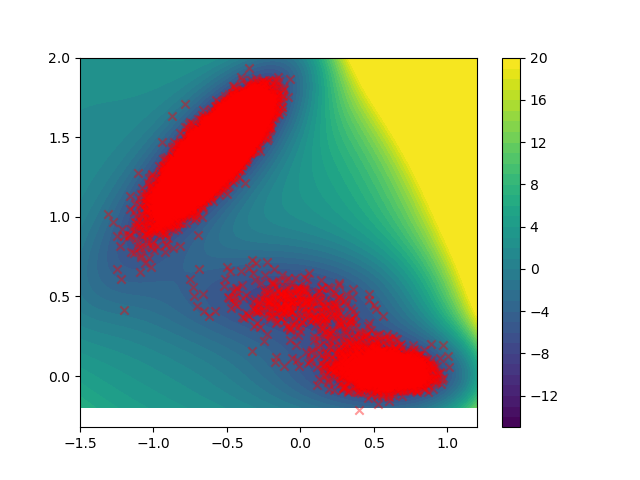

In [20]:
%matplotlib notebook

im = plt.contourf(xx, yy, plot_energies.clip(max=20), 40)
#im = plt.imshow(plot_energies, origin='lower', vmax=20.0)

plt.colorbar(im, ax=plt.gca())

plt.scatter(eq_data[:, 0], eq_data[:, 1], color='red', marker='x', alpha=0.4)